In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from utilities.FEM_2d_elasticity import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define grid and module types

In [3]:
coarse_grid = (2, 2)
res = 8
coarse_x, coarse_y = np.meshgrid(np.arange(coarse_grid[0]+1), np.arange(coarse_grid[1]+1))
coarse_coordinates = np.vstack([coarse_x.flatten(), coarse_y.flatten()]).T
x, y = np.meshgrid(np.linspace(0, coarse_grid[0], coarse_grid[0]*res+1), np.linspace(0, coarse_grid[1], coarse_grid[1]*res+1))
x = x.flatten()
y = y.flatten()
glob_numbering = np.reshape(np.arange(len(x)), (coarse_grid[0]*res+1, coarse_grid[1]*res+1))
coarse_idx = glob_numbering[0::res,0::res].flatten()

In [4]:
# Create module stiffness matrices
K_module = {}
K_module[(0, 0)] = create_module_domain(1, 0, 0.3, 0, 0, res)
for i in range(1, res//2 + 1):   
    for j in range(1, res//2 + 1):
        K_module[(i, j)] = create_module_domain(1, 0, 0.3, i, j, res)

## Example data

In [5]:
layout = [(1, 1), (1, 2), (2, 1), (3, 1)]
K_glob = assemble_global_stiffness(K_module, layout, coarse_grid, len(x), res)
support = [0, 1, 2*coarse_idx[2]+1]
force_idx = np.vstack([2*coarse_idx, 2*coarse_idx+1]).T.flatten()
coarse_with_BC_idx = np.setdiff1d(force_idx, support, assume_unique=True)
row_mask = np.isin(force_idx, coarse_with_BC_idx)
mask = np.outer(row_mask, row_mask)
F = np.zeros((2*len(x), len(coarse_with_BC_idx)))
for i in range(len(coarse_with_BC_idx)):
    F[coarse_with_BC_idx[i], i] = 1.
K_ff, F_f, dof = apply_BCs(K_glob, F, support)
U_ff = np.linalg.solve(K_ff, F_f)
U_glob = np.zeros((2*len(x), len(coarse_with_BC_idx)))
U_glob[dof] = U_ff
C_schur = U_glob[coarse_with_BC_idx]
K_schur = np.linalg.inv(C_schur)
K_schur_grid = np.zeros((len(force_idx), len(force_idx)))
K_schur_grid[mask] = K_schur.flatten()
C_schur_grid = np.zeros((len(force_idx), len(force_idx)))
C_schur_grid[mask] = C_schur.flatten()

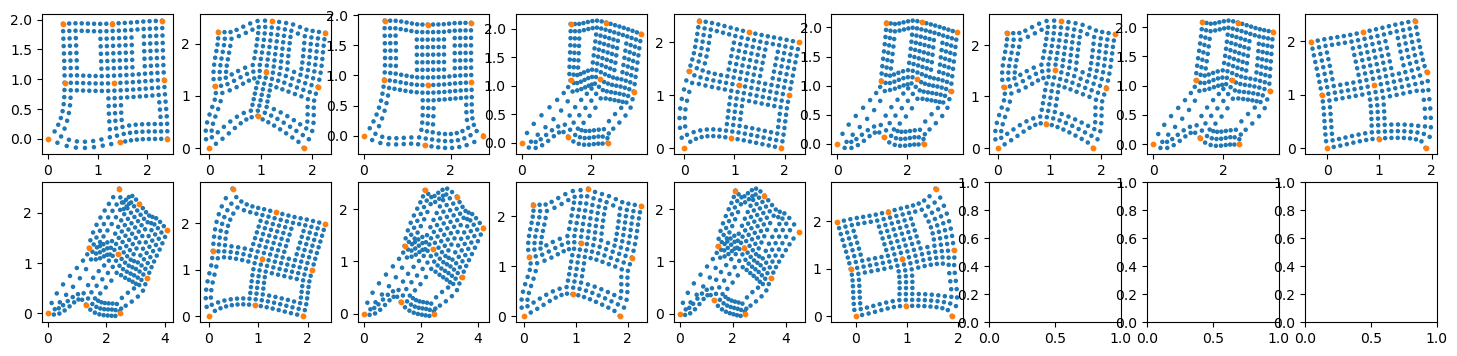

In [8]:
fig, axs = plt.subplots(2, 9, figsize=(18, 4))
for i in range(len(coarse_with_BC_idx)):
    axs.flat[i].scatter(x+0.05*U_glob[::2, i], y+0.05*U_glob[1::2, i], s=5, alpha=np.where(U_glob[::2, i]!=0, 1, 0))
    axs.flat[i].scatter(coarse_coordinates[:, 0]+0.05*C_schur_grid[np.diag(mask)][i, ::2], coarse_coordinates[:, 1]+0.05*C_schur_grid[np.diag(mask)][i, 1::2], s=10)

## Generate random structures on a grid

In [6]:
coarse_grid = (10, 10)
res = 16
coarse_x, coarse_y = np.meshgrid(np.arange(coarse_grid[0]+1), np.arange(coarse_grid[1]+1))
coarse_coordinates = np.vstack([coarse_x.flatten(), coarse_y.flatten()]).T
x, y = np.meshgrid(np.linspace(0, coarse_grid[0], coarse_grid[0]*res+1), np.linspace(0, coarse_grid[1], coarse_grid[1]*res+1))
x = x.flatten()
y = y.flatten()
glob_numbering = np.reshape(np.arange(len(x)), (coarse_grid[0]*res+1, coarse_grid[1]*res+1))
coarse_idx = glob_numbering[0::res,0::res].flatten()
choices = list(K_module.keys())
choices.remove((0, 0))

In [ ]:
for n in range(7200):
    U_ff = None
    while U_ff is None:
        try:
            layout = generate_structure(coarse_grid, choices)
            K_glob = assemble_global_stiffness(K_module, layout.reshape(2, -1).T, coarse_grid, len(x), res)
            support_coarse = generate_support_bridge(coarse_grid, layout)
            support = 2 * coarse_idx[np.array(support_coarse) // 2] + (np.array(support_coarse) % 2)
            force_idx = np.vstack([2*coarse_idx, 2*coarse_idx+1]).T.flatten()
            coarse_with_BC_idx = np.setdiff1d(force_idx, support, assume_unique=False)
            row_mask = np.isin(force_idx, coarse_with_BC_idx)
            mask = np.outer(row_mask, row_mask)
            F = np.zeros((2*len(x), len(coarse_with_BC_idx)))
            for i in range(len(coarse_with_BC_idx)):
                F[coarse_with_BC_idx[i], i] = 1.
            K_ff, F_f, dof = apply_BCs(K_glob, F, support)
            U_ff = np.linalg.solve(K_ff.astype(np.float32), F_f.astype(np.float32))
        except:
            print('Support problems')
            U_ff = None
    U_glob = np.zeros((2*len(x), len(coarse_with_BC_idx)))
    U_glob[dof] = U_ff

    data = {}

    C_schur_wBC = U_glob[coarse_with_BC_idx]
    C_schur_grid = np.zeros((len(force_idx), len(force_idx)))
    C_schur_grid[mask] = C_schur_wBC.flatten()
    data['C'] = torch.tensor(C_schur_grid)

    zero_map = np.where(np.diag(C_schur_grid)==0, False, True)
    zero_map = ~np.outer(zero_map, zero_map)
    data['zero_map'] = torch.tensor(zero_map)

    F_coarse = torch.eye(C_schur_grid.shape[0])
    F_coarse[zero_map] = 0
    data['F'] = F_coarse

    C_schur = C_schur_grid[np.ix_(np.diag(~zero_map), np.diag(~zero_map))]
    K_schur = np.linalg.inv(C_schur)
    K_schur_grid = np.zeros((len(force_idx), len(force_idx)))
    K_schur_grid[~zero_map] = K_schur.flatten()
    data['K'] = torch.tensor(K_schur_grid)

    DBC = torch.eye(C_schur_grid.shape[0])
    DBC[~zero_map] = 0
    data['DBC'] = DBC

    data['layout'] = torch.tensor(layout)
    
    with open(f'data/elast_{res}_{coarse_grid[0]}x{coarse_grid[1]}/{n}.pickle', 'wb') as handle:
         pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print(n)